<a href="https://colab.research.google.com/github/jikerbug/model_hub/blob/main/2_QDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we want to implement a first example of Quantum Machine Learning applied to a dataset.

In classical Machine Learning you usually start with the MNIST dataset and therefore we want to tackle it in this example as well!

Although this model is not "serious" in the sense that it wont be competitive with classical models and there is no "advantage", it is a nice example to get used to pennylane and the workflow to train qml models.

In [ ]:
!pip install pennylane --quiet

First we import some neccesary packages. We will again use pennylane for all things quantum!

In [ ]:
import pennylane as qml
import pennylane.numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
!mkdir Particle_Images
!cd Particle_Images
!mkdir data/
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

mkdir: cannot create directory ‘Particle_Images’: File exists
mkdir: cannot create directory ‘data/’: File exists
--2023-07-06 10:34:26--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/sHjzCNFTFxutYCj/download [following]
--2023-07-06 10:34:27--  https://cernbox.cern.ch/s/sHjzCNFTFxutYCj/download
Reusing existing connection to cernbox.cern.ch:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron     [              <=>   ]  82.98M  21.3MB/s    in 4.6s    

2023-07-06 10:34:33 (18.2 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508]

--2023-07-06 10:34:33--  https://cernb

In [ ]:
lr_init     = 1.e-3    # Initial learning rate
batch_size  = 64       # Training batch size
train_size  = 1024     # Training size
valid_size  = 1024     # Validation size
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs
doGPU       = True    # Use GPU

import h5py


if doGPU:
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

## Data

Next we will download the MNIST dataset from keras and normalize it.

In [ ]:
img_rows, img_cols, nb_channels = 32, 32, 2
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
x_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
x_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
x_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 2048
Number of original test examples: 2048


In order to simplify the problem, we will restrict us to a subset of the full dataset.

In [ ]:
n_train_per_class = 200
n_test_per_class = 1000

Furthermore, we will limit to the images of threes and sixes, to have a binary classification problem.
To do so, we filter out the images from the training data based on the label.

In [ ]:
def filter_36(x, y, n_samples):
    # keep3 = (y == 3)
    # keep6 = (y == 6)
    # x = np.concatenate((x[keep3][:n_samples], x[keep6][:n_samples]))
    # y = np.concatenate((y[keep3][:n_samples], y[keep6][:n_samples]))
    y = y == 1
    y = 2*y - 1
    return shuffle(x, y, random_state = 0)

In [ ]:
x_train, y_train = filter_36(x_train, y_train, n_train_per_class )
x_test, y_test = filter_36(x_test, y_test, n_test_per_class )

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 2048
Number of filtered test examples: 2048


Let's have a look at an example image

1


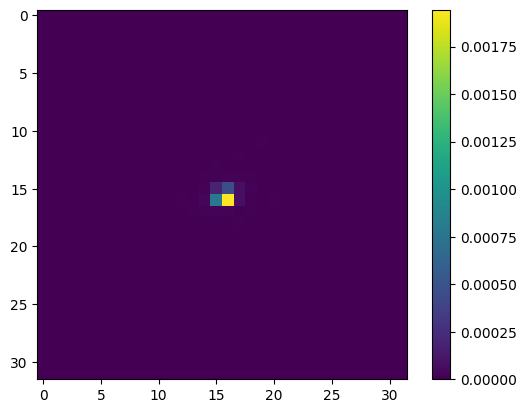

In [ ]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

A single images has 28x28=784 pixels, which are the features of our classification task. To use a smaller amount of qubits, we will reduce the dimensionality of the dataset.
In this example we will use a data embedding of a single feature per qubit (Angle Encoding), therefore reducing the dataset to the number of qubits.

To do we will use a principle component analysis. Now this is a very simple technique for dimensionality reduction, however, we need to be careful with the interpretation of the results. Although the PCA is quite simple, it can be a powerful tool on simple datasets like MNIST.

The resulting principle components might already seperate the two classes sufficiently, that a cut on a single feature after the PCA gives a good calssification accuracy.

In [ ]:
n_qubits = 3
n_features = n_qubits

In [ ]:
len(x_train)

2048

In [ ]:
pca = PCA(n_components=n_features)

x_train = pca.fit_transform(x_train.reshape(-1, 32 * 32 * 2))
x_test = pca.transform(x_test.reshape(-1, 32 * 32 * 2))

To prepare the data we normalize it and scale it to an interval of $2\pi$ for the rotational gates of the embedding.

In [ ]:
norm = np.max(x_train)

x_train = x_train/norm*np.pi
x_test = x_test/norm*np.pi

In [ ]:
x_train.shape
print(y_train.shape)

(2048,)


As an example we will plot a single principle

(array([  2.,   4.,  16.,  57., 288., 482., 112.,  39.,  18.,   6.]),
 array([-2.77130532, -2.24627638, -1.72124767, -1.19621885, -0.67119002,
        -0.1461612 ,  0.37886763,  0.90389645,  1.42892528,  1.9539541 ,
         2.47898293]),
 [<matplotlib.patches.Polygon at 0x7f996a1f61d0>])

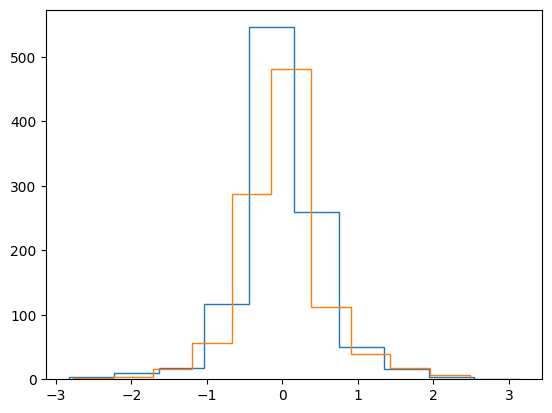

In [ ]:
plt.hist(x_train[:,0][y_train == -1],histtype='step')
plt.hist(x_train[:,0][y_train == 1],histtype='step')

As we can see, the PCA already separates the two classes on the first component sufficiently, so that the classification becomes a trivial problem.

However, as an example, we will still try to classify this dataset and are expecting to obtain good results on the classification.

## Circuit setup

We will now set up the circuits for our model. We will start with a very simple quantum neural network.

The network will consist of
1. A circuit to load the classical data into a quantum state
2. A parametrized quantum circuit corresponding to the classifier
3. A measurement to perform the classification

First we create a device

In [ ]:
dev = qml.device('lightning.qubit', wires=n_qubits)

Next we write the circuit to embed the data. Here we use the simplest embedding possible called 'Angle Embedding'.
It embeds a single feature on a single qubit, by rotating the state of the qubit by an angle corresponding to the classical feature value. If we denote our features by $x_i$ and choose to rotate around the $x$ axis of the bloch sphere the embedding would be
$$R_x(x_i)\big|\ 0\big>.$$

There is also a layer in pennylane which implements this [embedding](https://docs.pennylane.ai/en/stable/code/api/pennylane.AngleEmbedding.html), but we will do it by hand as an exercise.

In [ ]:
def embedding(data):
  for idx, x in enumerate(data):
    qml.RX(x,wires=idx)

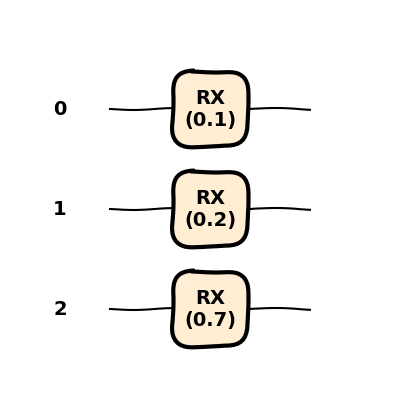

In [ ]:
import matplotlib.pyplot as plt
qml.draw_mpl(embedding, decimals=1, style="sketch")(x_train[0])
plt.show()

Next up, we will construct the parameterized circuit corresponding to our model. In general, there are not many guidelines how to do this yet. In this example, we will use a popular heuristic ansatz consiting of a layer of arbitrary qubit rotations and entanglement by CNOTs in an circular topology.

The arbitrary single qubit rotation can be constructed with the following ansatz (sometimes called Z-Y ansatz):
$$U = R_z(\alpha)R_y(\beta)R_z(\gamma)$$
Can you show why this is an arbitrary single qubit rotation ?

In pennylane the arbitrary single qubit is also implemented as [Rot-Gate](https://docs.pennylane.ai/en/stable/code/api/pennylane.Rot.html), but we will implement it by hand using rotation gates.

In [ ]:
def layer(params):
  for i in range(n_qubits):
    qml.RZ(params[i],wires=i)
  for i in range(n_qubits):
    qml.RY(params[i+n_qubits],wires=i)
  for i in range(n_qubits):
    qml.RZ(params[i+2*n_qubits],wires=i)
  for i in range(n_qubits):
    if i < n_qubits - 1:
      qml.CNOT(wires=[i,i+1])
    else:
      qml.CNOT(wires=[i,0])

Alternatively, the whole layer is implemented in pennylane as well named [StronglyEntanglingLayer](https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html).
Feel free to modify the example using this layer (however check the documentation, as the parameters passed to this layer need to take a certain shape).

Now we can build a model circuit by adding an arbitrary number of subsequent layers. Note how we need to take care of passing a different set of parameters to every layer.

In [ ]:
layers = 3

In [ ]:
def model_pqc(params):
  for i in range(layers): layer(params[i*3*n_qubits:(i+1)*3*n_qubits])

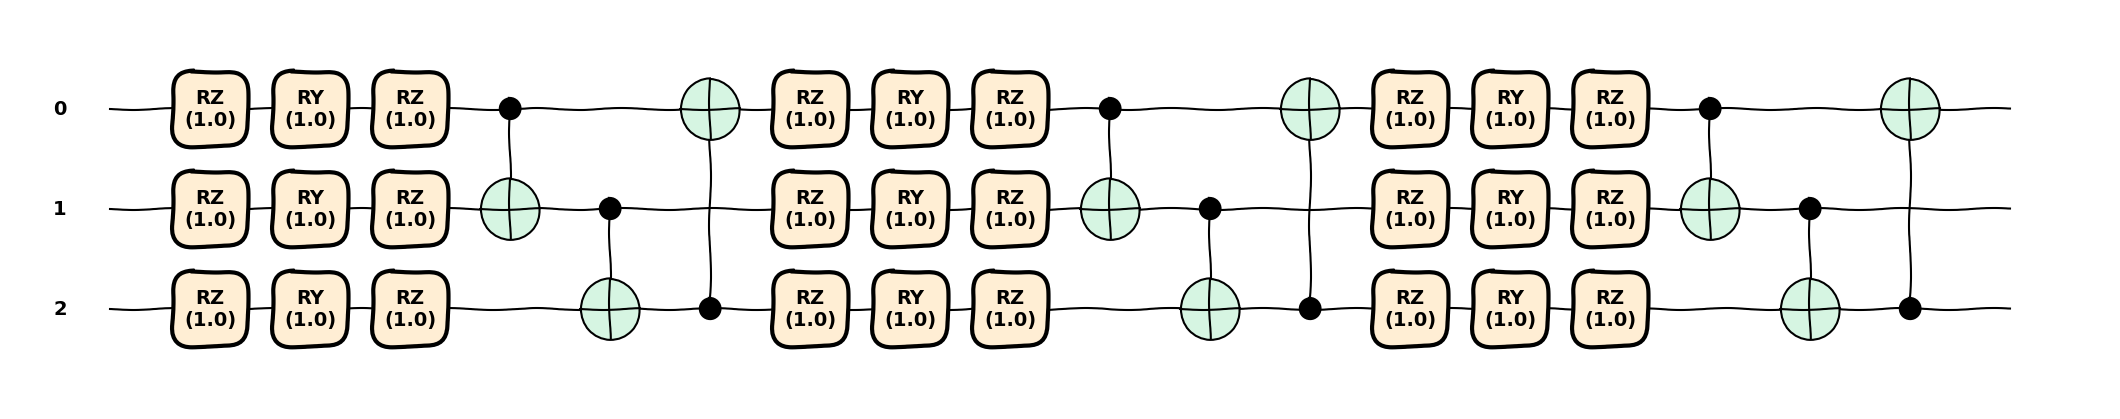

In [ ]:
qml.draw_mpl(model_pqc, decimals=1, style="sketch")(np.ones(layers*3*n_qubits))
plt.show()

Now we are ready to build our final training circuit. This circuit will include the data embedding, the model pqc and a measurement, and we will create it as a QNode, as it will be the final circuit we will be executing. As measurement, we will be measuring the qubit 0.

In [ ]:
@qml.qnode(dev)
def training_circuit(data, params):
  embedding(data)
  model_pqc(params)
  return qml.expval(qml.PauliZ(0))

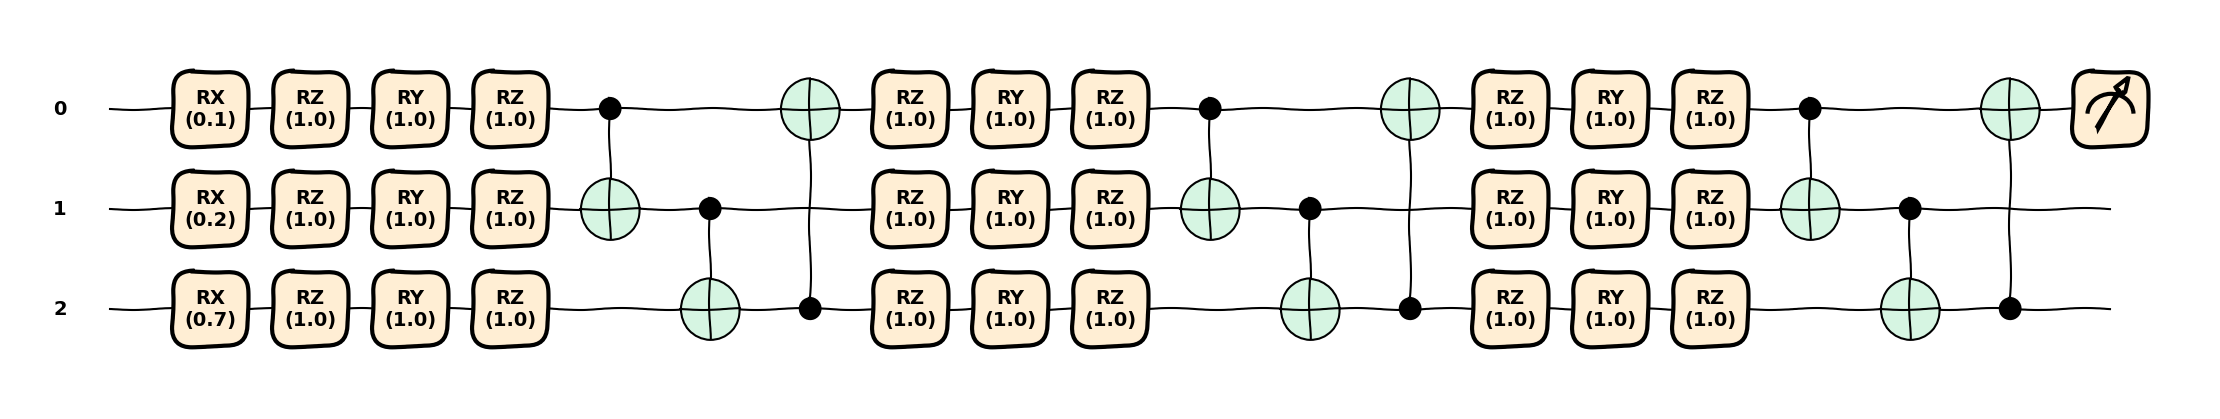

In [ ]:
qml.draw_mpl(training_circuit, decimals=1, style="sketch")(x_train[0], np.ones(layers*3*n_qubits))
plt.show()

# Training

To train the circuit, we will define a loss function and an optimizer which will train our parameters while we loop over the training data.

In our training dataset we assigned the labels $1$ and $-1$ to our two classes.
In our training circuit we are measuring in the PauliZ basis. Since $\sigma_z$ has eigenvalues $\pm 1$ the measurement results exaclty corresponds to the label of the class.

We can therefore write down a simple loss function. Here we will use the [Hinge loss](https://en.wikipedia.org/wiki/Hinge_loss), which expects the labels to be $\pm 1$.

Note, that we construct the loss function to take in a batch of data and the parameters of the circuit.
We then loop over the samples in the batch and exercute the circuit for the data with the given parameters to calculate the loss value.

In [ ]:
def loss(batch_x, batch_y, params):
  loss = 0
  for idx, x in enumerate(batch_x):
    y_pred = training_circuit(x,params)
    loss += np.maximum(1 - batch_y[idx] * y_pred, 0)
  return loss / len(batch_x)

Like in th eprevious examples we will now define our initial parameters. Here we again have to specify the keyword **requires_grad** to indicate that these are parameters we want to optimize.

In [ ]:
params = np.array(np.random.uniform(size=layers*3*n_qubits), requires_grad=True)*np.pi

To loop over our data we furthermore write a function to split our data into batches

In [ ]:
def iterate_minibatches(dataX, dataY, batch_size):
    for start_idx in range(0, dataX.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield dataX[idxs], dataY[idxs]

Also we want to keep track of the accuracy of the model

In [ ]:
def accuracy(dataX, dataY, params):
  acc = 0
  for idx, x in enumerate(dataX):
    pred = -1 if training_circuit(x, params) < 0 else 1
    if pred == dataY[idx]: acc += 1
  return acc / len(dataX)

Now we are ready to train!

In [ ]:
epochs = 6
batch_size = 16
lr = 0.01

In [ ]:
opt = qml.AdamOptimizer(stepsize=lr)

And write down the training loop. Note, that we define the cost function with a [lambda function](https://www.w3schools.com/python/python_lambda.asp) for every batch of data, since our optimizer expects a function with a single argrument, which will be optimized.

For every epoch, we loop over all batches of data and perform an optimzation step for every batch.

In [ ]:
print('hello')

import time
start = time.time()

loss_hist = []
acc_hist = []

for it in range(epochs):
    # loop over batches of data
    for j,data in enumerate(iterate_minibatches(x_train, y_train, batch_size=batch_size)):
        Xbatch, Ybatch = data
        # define cost function for specific batch
        cost_fn = lambda p: loss(Xbatch, Ybatch, p)
        params = opt.step(cost_fn, params)
        print(j, end="\r")

    loss_val = loss(x_train, y_train, params)
    acc = accuracy(x_train, y_train, params)

    loss_hist += [loss_val]
    acc_hist += [acc]

    print(f"Epoch: {it} | Loss: {loss_val:.3} | acc: {acc:.3} ")
    print("____")

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

hello
Epoch: 0 | Loss: 0.997 | acc: 0.5 
____
Epoch: 1 | Loss: 0.994 | acc: 0.514 
____
Epoch: 2 | Loss: 0.99 | acc: 0.518 
____
Epoch: 3 | Loss: 0.986 | acc: 0.522 
____
Epoch: 4 | Loss: 0.983 | acc: 0.52 
____
Epoch: 5 | Loss: 0.981 | acc: 0.52 
____
Time for 6 epochs: 2329.4719812870026


Text(0, 0.5, 'loss')

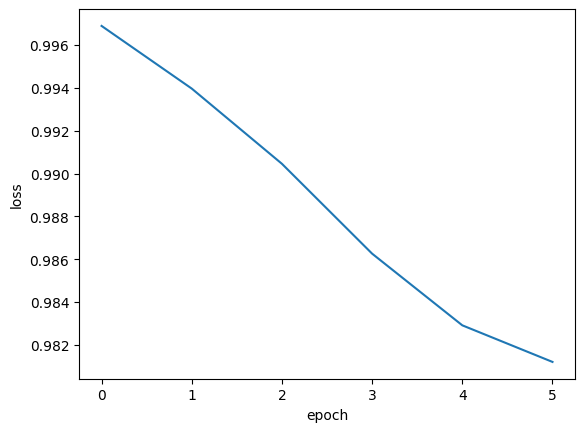

In [ ]:
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'Accuracy')

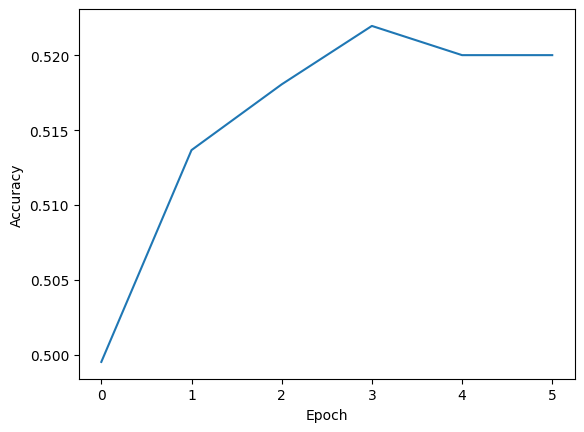

In [ ]:
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("loss")

plt.plot(acc_hist)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()